In [683]:
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit_machine_learning.connectors import TorchConnector
from qiskit.primitives import StatevectorSampler as Sampler
from qiskit_machine_learning.neural_networks import SamplerQNN
from torch.optim import Adam
from IPython.display import clear_output

In [684]:
import torch
from qiskit_machine_learning.utils import algorithm_globals

algorithm_globals.random_seed = 123456

In [685]:
import numpy as np

num_dim = 2
num_discrete_values = 8

In [711]:
from scipy.stats import lognorm
import numpy as np
from scipy.stats import lognorm, triang, norm

# Parameters
n_samples = 20000
lower_limit = 0
upper_limit = 7

# 1. Log-normal distribution (μ = 1, σ = 1)
# Log-normal parameters: s = σ, scale = exp(μ)
sigma = 1
mu = 1
rv = lognorm(s=sigma, scale=np.exp(mu))
lognorm_samples = rv.rvs(size=n_samples)
lognorm_samples = np.clip(lognorm_samples, lower_limit, upper_limit)  # Truncate
lognorm_samples = np.round(lognorm_samples).astype(int)  # Round to integers
 # Create discrete coordinates in the given space
coords = np.linspace(0, 7, num_discrete_values)
grid_elements = np.transpose([np.tile(coords, len(coords)), np.repeat(coords, len(coords))])
prob_data = rv.pdf(grid_elements[:, 0]) * rv.pdf(grid_elements[:, 1])
prob_data = np.clip(prob_data, 0, None)  # Remove negative values
# Add smoothing to avoid zeros
epsilon = 1e-12
prob_data = prob_data + epsilon
prob_data = prob_data / np.sum(prob_data)



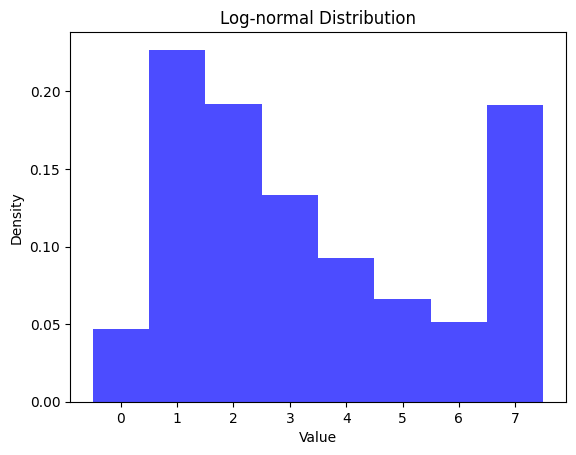

In [710]:
import matplotlib.pyplot as plt
from matplotlib import cm

mesh_x, mesh_y = np.meshgrid(coords, coords)
grid_shape = (num_discrete_values, num_discrete_values)

# fig, ax = plt.subplots(figsize=(9, 9), subplot_kw={"projection": "3d"})
# prob_grid = np.reshape(prob_data, grid_shape)
# surf = ax.plot_surface(mesh_x, mesh_y, prob_grid, cmap=cm.coolwarm, linewidth=0, antialiased=False)
# fig.colorbar(surf, shrink=0.5, aspect=5)

plt.hist(lognorm_samples, bins=np.arange(-0.5, 8.5), density=True, color='blue', alpha=0.7)
plt.title('Log-normal Distribution')
plt.xlabel('Value')
plt.ylabel('Density')
plt.show()

Log-normal samples count: 20000
Log-normal samples range: 0 7
Triangular samples count: 20000
Triangular samples range: 0 7
Bimodal samples count: 20000
Bimodal samples range: 0 5


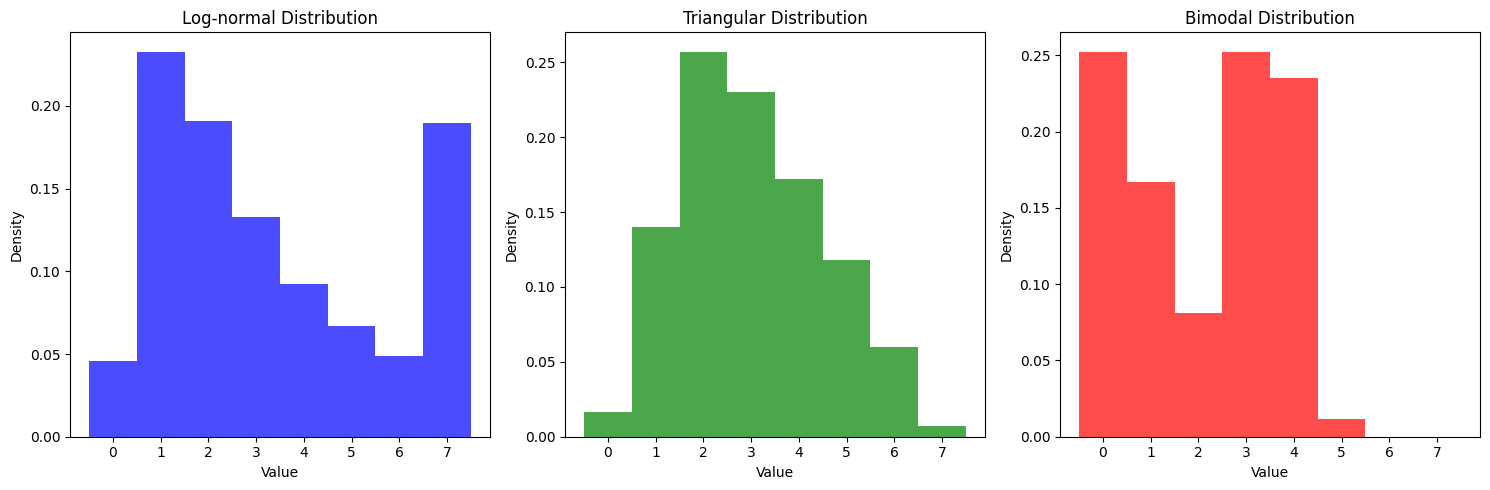

In [ ]:
# For further use

# 2. Triangular distribution (l = 0, m = 2, u = 7)
c = (2 - 0) / (7 - 0)  # Shape parameter c = (mode - lower) / (upper - lower)
triang_rv = triang(c=c, loc=0, scale=7)
triang_samples = triang_rv.rvs(size=n_samples)
triang_samples = np.clip(triang_samples, lower_limit, upper_limit)  # Truncate
triang_samples = np.round(triang_samples).astype(int)  # Round to integers

# 3. Bimodal distribution (two Gaussians: μ1=0.5, σ1=1; μ2=3.5, σ2=0.5)
# Generate samples from each Gaussian and mix equally
norm1_rv = norm(loc=0.5, scale=1)
norm2_rv = norm(loc=3.5, scale=0.5)
norm1_samples = norm1_rv.rvs(size=n_samples // 2)
norm2_samples = norm2_rv.rvs(size=n_samples // 2)
bimodal_samples = np.concatenate([norm1_samples, norm2_samples])
np.random.shuffle(bimodal_samples)  # Mix the samples
bimodal_samples = np.clip(bimodal_samples, lower_limit, upper_limit)  # Truncate
bimodal_samples = np.round(bimodal_samples).astype(int)  # Round to integers

# Verify sample counts and ranges
print("Log-normal samples count:", len(lognorm_samples))
print("Log-normal samples range:", lognorm_samples.min(), lognorm_samples.max())
print("Triangular samples count:", len(triang_samples))
print("Triangular samples range:", triang_samples.min(), triang_samples.max())
print("Bimodal samples count:", len(bimodal_samples))
print("Bimodal samples range:", bimodal_samples.min(), bimodal_samples.max())

# Optional: Visualize histograms to check the distributions
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.hist(lognorm_samples, bins=np.arange(-0.5, 8.5), density=True, color='blue', alpha=0.7)
plt.title('Log-normal Distribution')
plt.xlabel('Value')
plt.ylabel('Density')

plt.subplot(1, 3, 2)
plt.hist(triang_samples, bins=np.arange(-0.5, 8.5), density=True, color='green', alpha=0.7)
plt.title('Triangular Distribution')
plt.xlabel('Value')
plt.ylabel('Density')

plt.subplot(1, 3, 3)
plt.hist(bimodal_samples, bins=np.arange(-0.5, 8.5), density=True, color='red', alpha=0.7)
plt.title('Bimodal Distribution')
plt.xlabel('Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

In [688]:
# Set circuit depth variable and qubit number
k = 3
qubit_num = 6

In [689]:
# Prepare the initial state |Ψin> according to a discrete uniform distribution 
def initialize_state(qubit_num):
    qc = QuantumCircuit(qubit_num)
    qc.h(qc.qubits)
    return qc

In [690]:
def create_variational_form(qubit_num, reps):
    """
    Creates a variational circuit with Ry rotations and linear CZ entangling layers,
    repeated 'reps' times as shown in the given figure.
    """
    qc = initialize_state(qubit_num)
    params = ParameterVector('θ', length=qubit_num * reps)
    param_idx = 0

    # Layer of Ry gates
    for qubit in range(qubit_num):
        qc.ry(params[param_idx], qubit)
        param_idx += 1
    qc.barrier()

    param_idx = 0
    for _ in range(reps):
        # Linear entanglement with CZ gates
        for qubit in range(qubit_num - 1):
                qc.cz(qubit, qubit + 1)
        qc.cz(qubit_num - 1, 0)
        qc.barrier()

        # Layer of Ry gates
        for qubit in range(qubit_num):
            qc.ry(params[param_idx], qubit)
            param_idx += 1
        qc.barrier()

    return qc, params


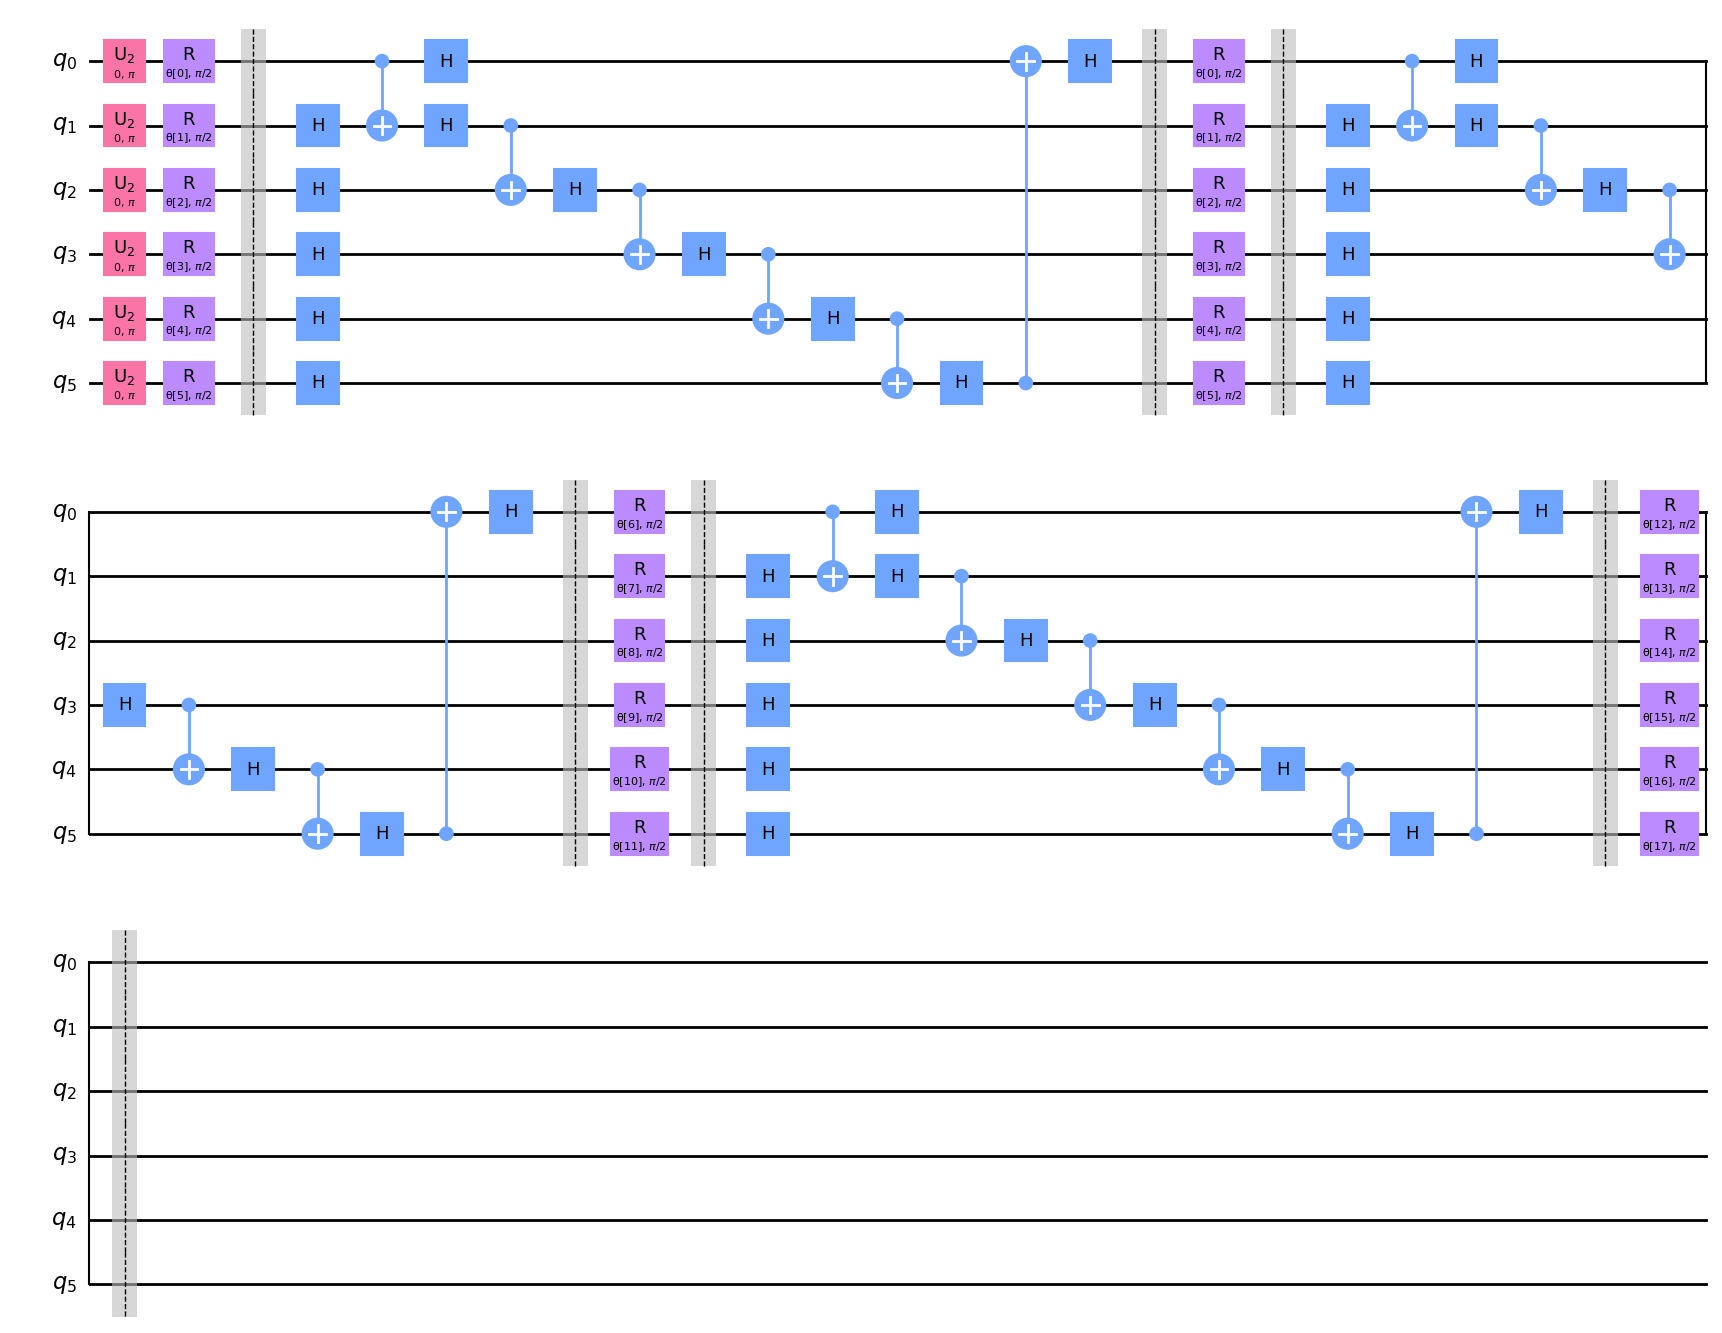

In [691]:
qc, params = create_variational_form(qubit_num, k)
#qc.compose(circuit, inplace=True)
qc.decompose().draw(output="mpl", style="clifford")

In [692]:
sampler = Sampler()
def create_quantum_generator()->TorchConnector:
    qnn = SamplerQNN(
        circuit=qc,
        sampler=sampler,
        input_params=[],
        weight_params=params,
        sparse=False,
    )

    initial_weights = algorithm_globals.random.random(qc.num_parameters)
    return TorchConnector(qnn, initial_weights)       

In [693]:
import torch
import torch.nn as nn

class Discriminator(nn.Module):
    def __init__(self, input_size):
        """
        Discriminator neural network with specified architecture
        
        Args:
            input_size (int): Number of input features (dimension of input data)
            
        Architecture:
            - Input layer:    (input_size) → 50 nodes
            - Hidden layer:   50 → 20 nodes
            - Output layer:   20 → 1 node
            - Activation:    LeakyReLU(0.2) for input/hidden, Sigmoid for output
        """
        super().__init__()
        self.model = nn.Sequential(
            # Input layer (50 nodes)
            nn.Linear(input_size, 50),
            # Activation function
            nn.LeakyReLU(negative_slope=0.2),
            # Hidden layer (20 nodes)
            nn.Linear(50, 20),
            # Activation function
            nn.LeakyReLU(negative_slope=0.2),
            # Output layer (1 node)
            nn.Linear(20, 1),
            # Normalize output in [0,1]
            nn.Sigmoid()
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass through the network
        
        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, input_size)
            
        Returns:
            torch.Tensor: Output probability tensor of shape (batch_size, 1)
        """
        return self.model(x)

In [694]:
generator = create_quantum_generator()
discriminator = Discriminator(num_dim)

No gradient function provided, creating a gradient function. If your Sampler requires transpilation, please provide a pass manager.


In [695]:
def adversarial_loss(input, target, w):
    bce_loss = target * torch.log(input) + (1 - target) * torch.log(1 - input)
    weighted_loss = w * bce_loss
    total_loss = -torch.sum(weighted_loss)
    return total_loss

In [696]:
b1 = 0.7  # first momentum parameter
b2 = 0.999  # second momentum parameter

generator_optimizer = Adam(generator.parameters(), lr=0.001, betas=(b1, b2), weight_decay=0.005, amsgrad = True)
discriminator_optimizer = Adam(discriminator.parameters(), lr=0.001, betas=(b1, b2), weight_decay=0.005, amsgrad = True)

In [697]:
from IPython.display import clear_output


def plot_training_progress():
    # we don't plot if we don't have enough data
    if len(generator_loss_values) < 2:
        return

    clear_output(wait=True)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 9))

    # Generator Loss
    ax1.set_title("Loss")
    ax1.plot(generator_loss_values, label="generator loss", color="royalblue")
    ax1.plot(discriminator_loss_values, label="discriminator loss", color="magenta")
    ax1.legend(loc="best")
    ax1.set_xlabel("Iteration")
    ax1.set_ylabel("Loss")
    ax1.grid()

    # Relative Entropy
    # ax2.set_title("Relative entropy")
    # ax2.plot(entropy_values)
    # ax2.set_xlabel("Iteration")
    # ax2.set_ylabel("Relative entropy")
    # ax2.grid()

    plt.show()

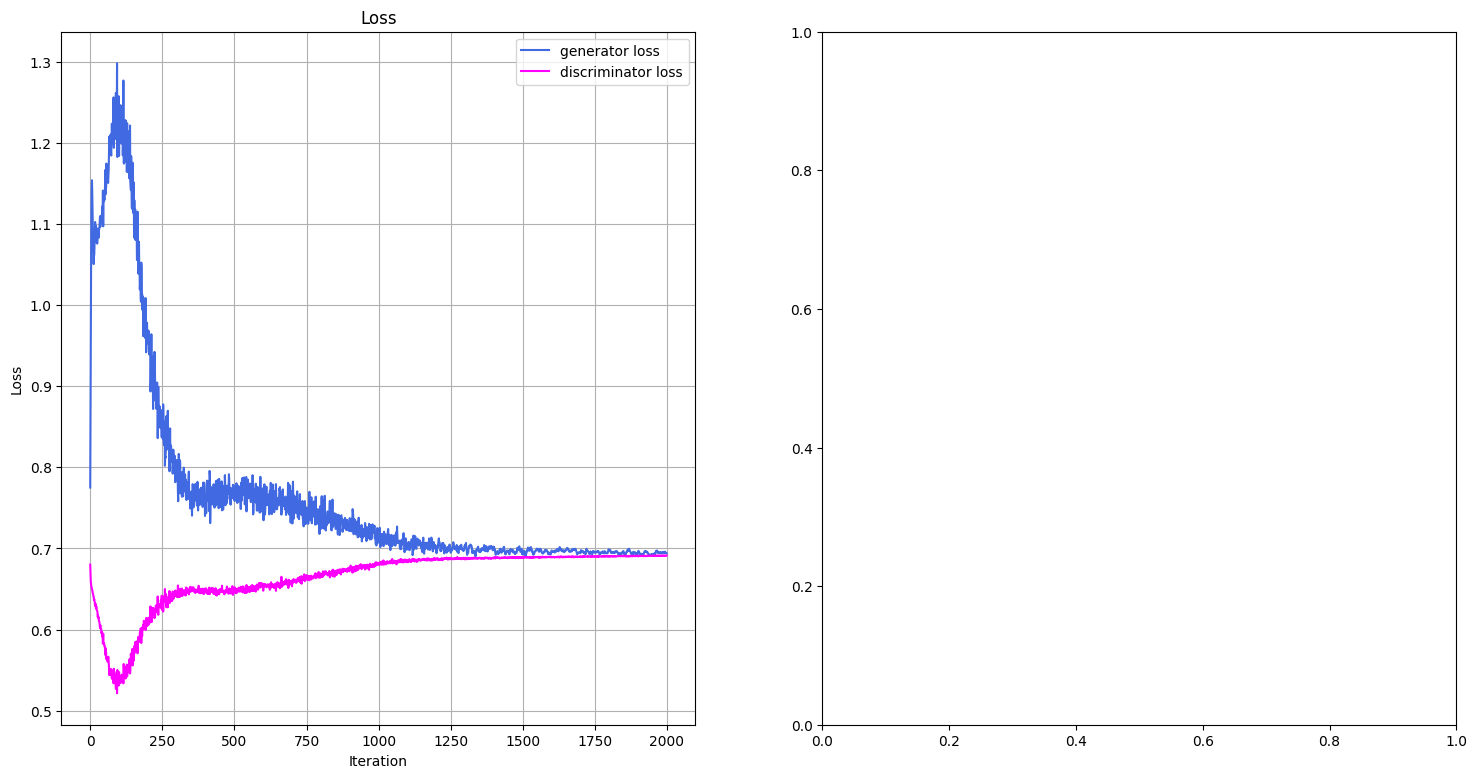

Fit in 913.00 sec


In [698]:
import time
from scipy.stats import multivariate_normal, entropy

n_epochs = 2000

num_qnn_outputs = num_discrete_values**num_dim
generator_loss_values = []
discriminator_loss_values = []
entropy_values = []

start = time.time()
for epoch in range(n_epochs):

    valid = torch.ones(num_qnn_outputs, 1, dtype=torch.float)
    fake = torch.zeros(num_qnn_outputs, 1, dtype=torch.float)

    # Configure input
    real_dist = torch.tensor(prob_data, dtype=torch.float).reshape(-1, 1)

    # Configure samples
    samples = torch.tensor(grid_elements, dtype=torch.float)
    disc_value = discriminator(samples)

    # Generate data
    gen_dist = generator(torch.tensor([])).reshape(-1, 1)

    # Train generator
    generator_optimizer.zero_grad()
    generator_loss = adversarial_loss(disc_value, valid, gen_dist)

    # store for plotting
    generator_loss_values.append(generator_loss.detach().item())

    generator_loss.backward(retain_graph=True)
    generator_optimizer.step()

    # Train Discriminator
    discriminator_optimizer.zero_grad()

    real_loss = adversarial_loss(disc_value, valid, real_dist)
    fake_loss = adversarial_loss(disc_value, fake, gen_dist.detach())
    discriminator_loss = (real_loss + fake_loss) / 2

    # Store for plotting
    discriminator_loss_values.append(discriminator_loss.detach().item())

    discriminator_loss.backward()
    discriminator_optimizer.step()

    gen_dist_norm = gen_dist.detach().squeeze().numpy()
    # gen_dist_norm = gen_dist_norm / np.sum(gen_dist_norm)
    # prob_data = prob_data / np.sum(prob_data)
    entropy_value = entropy(gen_dist_norm, prob_data)
    entropy_values.append(entropy_value)

    plot_training_progress()

elapsed = time.time() - start
print(f"Fit in {elapsed:0.2f} sec")

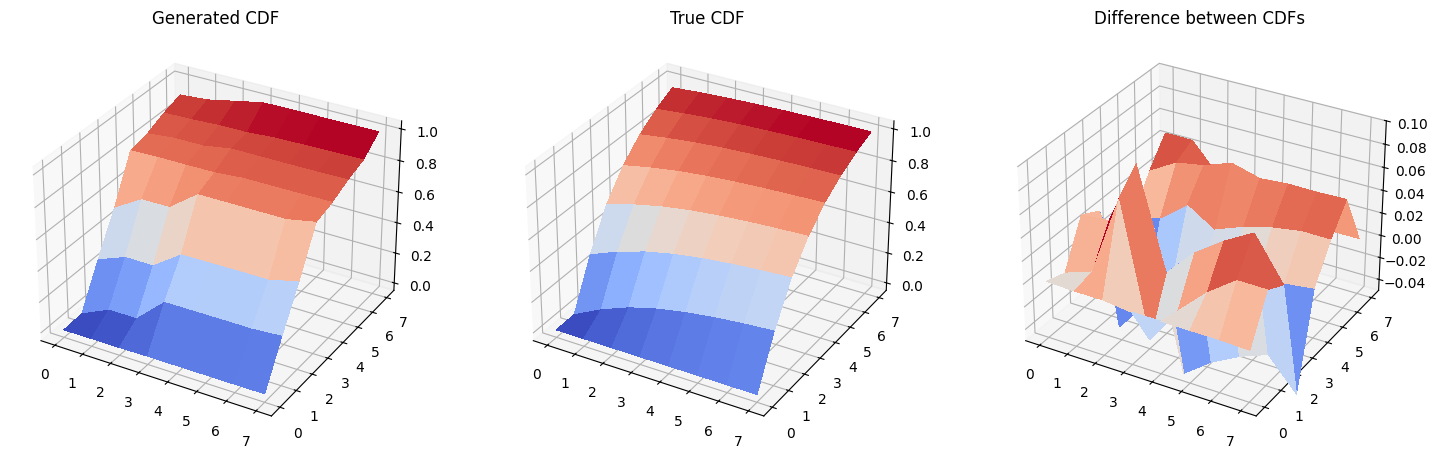

In [699]:
with torch.no_grad():
    generated_probabilities = generator().numpy()

fig = plt.figure(figsize=(18, 9))

# Generated CDF
gen_prob_grid = np.reshape(np.cumsum(generated_probabilities), grid_shape)

ax1 = fig.add_subplot(1, 3, 1, projection="3d")
ax1.set_title("Generated CDF")
ax1.plot_surface(mesh_x, mesh_y, gen_prob_grid, linewidth=0, antialiased=False, cmap=cm.coolwarm)
ax1.set_zlim(-0.05, 1.05)

# Real CDF
real_prob_grid = np.reshape(np.cumsum(prob_data), grid_shape)

ax2 = fig.add_subplot(1, 3, 2, projection="3d")
ax2.set_title("True CDF")
ax2.plot_surface(mesh_x, mesh_y, real_prob_grid, linewidth=0, antialiased=False, cmap=cm.coolwarm)
ax2.set_zlim(-0.05, 1.05)

# Difference
ax3 = fig.add_subplot(1, 3, 3, projection="3d")
ax3.set_title("Difference between CDFs")
ax3.plot_surface(
    mesh_x, mesh_y, real_prob_grid - gen_prob_grid, linewidth=2, antialiased=False, cmap=cm.coolwarm
)
ax3.set_zlim(-0.05, 0.1)
plt.show()

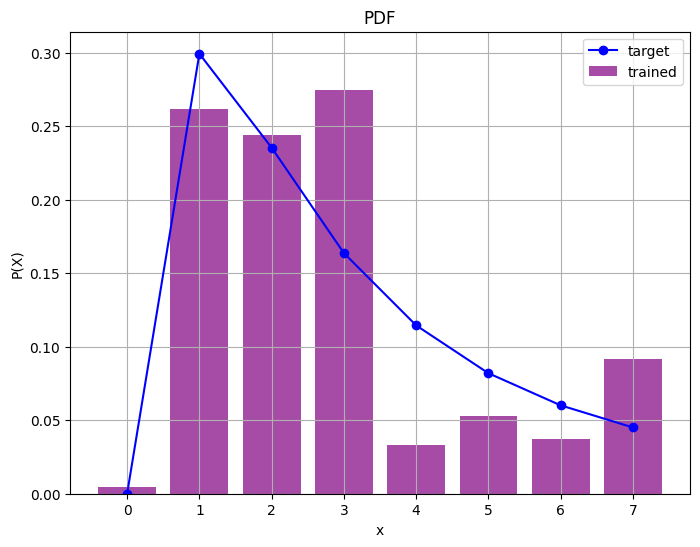

In [700]:
prob_data_2d = np.outer(rv.pdf(coords), rv.pdf(coords))

# Sum over y-axis to get marginal distribution over x
prob_data_marginal = prob_data_2d.sum(axis=1)  # Shape: (8,)
prob_data_marginal = prob_data_marginal / np.sum(prob_data_marginal)  # Normalize

# Marginalize the generated distribution similarly
gen_prob_2d = np.reshape(generated_probabilities, (num_discrete_values, num_discrete_values))
gen_prob_marginal = gen_prob_2d.sum(axis=1)  # Shape: (8,)
gen_prob_marginal = gen_prob_marginal / np.sum(gen_prob_marginal)  # Normalize

# Create the plot
fig = plt.figure(figsize=(8, 6))
plt.plot(coords, prob_data_marginal, label='target', color='blue', marker='o')
plt.hist(coords, bins=np.arange(0, 9) - 0.5, weights=gen_prob_marginal, label='trained', color='purple', alpha=0.7, rwidth=0.8)
plt.xlabel('x')
plt.ylabel('P(X)')
plt.title('PDF')
plt.legend()
plt.grid(True)
plt.show()